### 用Efficient DD的思路，使用一个辅助比特，在LimTDD上实现了态制备 - 对应 Alg. 2
Efficient Deterministic Preparation of Quantum States 
Using Decision Diagrams

In [8]:
import numpy as np
from TDD.TDD import TDD, Ini_TDD,Clear_TDD,set_index_order,get_unique_table_num,set_root_of_unit,get_count,cont,renormalize,Slicing2,Slicing,get_index_order
from TDD.TDD_Q import cir_2_tn,get_real_qubit_num,add_trace_line,add_inputs,add_outputs,gen_cir
from TDD.TN import Index,Tensor,TensorNetwork
import time
import random
from qiskit import QuantumCircuit,qasm2
import cProfile
from IPython.display import display, HTML,Image
# from PIL import Image
from PIL import Image as PILImage
import networkx as nx
import copy
from qiskit.circuit.library.standard_gates import HGate,U1Gate,U3Gate
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import UnitaryGate,MCXGate


to_test = False

In [9]:
def simulate(cir,ini=False,n=0):
    tn,all_indexs = cir_2_tn(cir)
    tn.tensors=[ts for ts in tn.tensors if ts.name!='nu_q']
    # n = get_real_qubit_num(cir)
    if n!=0:
        add_inputs(tn,[0]*n,n)

    if ini:
        var=[]
        for idx in all_indexs:
            if idx[0]=='x' and not '_' in idx:
                var.append('a'+idx[1:])
            var.append(idx)
            if idx[0]=='y' and not '_' in idx:
                var.append('b'+idx[1:])
#         print(var)
        for k1 in range(n):
            if not 'x'+str(k1) in var:
                var.append('x'+str(k1))
            for k in range(5*len(all_indexs)):
                s ='x'+str(k1)+'_'+str(k)
                if not s in var:
                    var.append(s)
                s ='y'+str(k1)+'_'+str(k)
                if not s in var:
                    var.append(s)               
            if not 'y'+str(k1) in var:
                var.append('y'+str(k1))
        var.reverse()
        Ini_TDD(index_order=var)
        set_root_of_unit(2**3)
    tdd=tn.cont()
    return tdd

def change_index(tdd,x,y):
    """change the index from x to y"""
    
    idx_set = []
    key_2_index  = dict()
    index_2_key = dict()
    
    for idx in tdd.index_set:
        if idx.key[0]==x:
            idx_set.append(Index(y+idx.key[1:],idx.idx))
        else:
            idx_set.append(idx)
    
    for k in tdd.key_2_index:
        if isinstance(tdd.key_2_index[k],str) and tdd.key_2_index[k][0]==x:
            key_2_index[k]=y+tdd.key_2_index[k][1:]
        else:
            key_2_index[k]=tdd.key_2_index[k]
            
    for k in tdd.index_2_key:
        if isinstance(k,str) and k[0]==x:
            index_2_key[y+k[1:]]=tdd.index_2_key[k]
        else:
            index_2_key[k]=tdd.index_2_key[k]
    tdd.index_set=idx_set
    tdd.key_2_index=key_2_index
    tdd.index_2_key = index_2_key
    
    
def update_tdd(tdd,cir_head,cir_end):
    tdd1 = simulate(cir_head)
    change_index(tdd1,'x','a')
    change_index(tdd1,'y','x')

    tdd2 = simulate(cir_end)
    change_index(tdd2,'y','b')
    change_index(tdd2,'x','y')
    
    tdd_new=cont(tdd,tdd1)
    tdd_new=cont(tdd_new,tdd2)

    change_index(tdd_new,'a','x')
    change_index(tdd_new,'b','y')
    # tdd_new=renormalize(tdd_new)
    return tdd_new

def get_downward_k_level_map(tdd,k,c):
    if k==0:
        if c==0:
            return tdd.node.out_maps[1],tdd.node.out_weight[1]
        else:
            return tdd.node.successor[0].out_maps[1],tdd.node.successor[0].out_weight[1]
    # temp_tdd = Slicing2(Slicing2(tdd,tdd.node.key,0),tdd.node.key-1,0)
    temp_tdd = Slicing2(tdd,tdd.node.key,0)
    return get_downward_k_level_map(temp_tdd,k-1,c)

def get_gate_data(cir):
    data = {}
    for d in cir.data:
        a = len(d.qubits)
        if a in data:
            data[a]+=1
        else:
            data[a]=1
    return data

def get_gate_data2(cir):
    data = 0
    for d in cir.data:
        data += len(d.qubits)
    return data

In [10]:
def get_controlled_circuit2(cir,cond = {0:1},add_qubits_num = 0):
    
    if add_qubits_num==0:
        add_qubits_num = len(cond)
    
    circ = QuantumCircuit(cir.num_qubits+add_qubits_num)

    for g, qargs, cargs in cir.data:
        cg = g.control(len(cond))
        new_qubits = [k for k in cond]
        for k in qargs:
            new_qubits.append(k._index)
        for k in cond:
            if cond[k]==0:
                circ.x(k)
        circ.append(cg,new_qubits)
        for k in cond:
            if cond[k]==0:
                circ.x(k)        
    return circ


def state_pre(tdd,n=0,cond={},anc_num=1):


    if tdd.node.key==-1:
        return QuantumCircuit(0),1
        
    if n==0:
        n = tdd.node.key+1
    cir = QuantumCircuit(n+1)
    qa = n
    
    the_map=tdd.map

    while the_map.level>-1:
        idx = the_map.level
        q = int(tdd.key_2_index[idx][1:])
        if the_map.x==1:
            cir.x(q)
        if the_map.rotate>0:
            cir.p(np.pi/4*(8-the_map.rotate),q)
        the_map=the_map.father
    
    u = tdd.node
    the_map = u.out_maps[1]
    
    while the_map.level>-1:
        q1 = u.key
        idx = the_map.level
        q = int(tdd.key_2_index[idx][1:])
        if the_map.x==1:
            cir.ccx(qa,q1,q)
        if the_map.rotate>0:
            cir.mcp(np.pi/4*(8-the_map.rotate),[qa, q1],q)
        the_map=the_map.father
    
    if u.successor[0]!=u.successor[1]:
        #把1分支关闭
        cond_qubit = [u.key] + [k for k in cond]
        for k in cond:
            if cond[k]==0:
                cir.x(k)
        # print('a',cond_qubit,qa)
        cir.mcx(cond_qubit,qa)
        for k in cond:
            if cond[k]==0:
                cir.x(k)
    
    # cond[u.key]=0
        bran_tdd = TDD(u.successor[0])
        n2 = bran_tdd.node.key+1
        bran_tdd.index_set = []
        bran_tdd.key_2_index ={-1:-1}
        bran_tdd.key_width = {}
        for k in range(n2):
            bran_tdd.index_set.append(Index('y'+str(k),0))
            bran_tdd.key_2_index[k] = 'y'+str(k)
            bran_tdd.key_width[k] = 2
        bran_tdd.index_2_key = {bran_tdd.key_2_index[a]:a for a in bran_tdd.key_2_index} 
        cir_end_t0, hold_prob0 = state_pre(bran_tdd,n,cond|{u.key:0},anc_num)
        cir=cir&cir_end_t0
    
    # if u.successor[0]!=u.successor[1]:
        #把0分支关闭，1分支打开
        cond_qubit = [k for k in cond]
        if len(cond_qubit)==0:
            cir.x(qa)
        else:
            for k in cond:
                if cond[k]==0:
                    cir.x(k)
            # print('b',cond_qubit,qa)
            cir.mcx(cond_qubit,qa)
            for k in cond:
                if cond[k]==0:
                    cir.x(k)
        
        bran_tdd = TDD(u.successor[1])
        n2 = bran_tdd.node.key+1
        bran_tdd.index_set = []
        bran_tdd.key_2_index ={-1:-1}
        bran_tdd.key_width = {}
        for k in range(n2):
            bran_tdd.index_set.append(Index('y'+str(k),0))
            bran_tdd.key_2_index[k] = 'y'+str(k)
            bran_tdd.key_width[k] = 2
        bran_tdd.index_2_key = {bran_tdd.key_2_index[a]:a for a in bran_tdd.key_2_index} 
        cir_end_t1, hold_prob1 = state_pre(bran_tdd,n,cond|{u.key:1},anc_num)
        cir=cir&cir_end_t1
        
        #把0分支再打开
        cond_qubit = [u.key] + [k for k in cond]
        cir.x(u.key)
        for k in cond:
            if cond[k]==0:
                cir.x(k)     
        # print('c',cond_qubit,qa)
        cir.mcx(cond_qubit,qa)
        for k in cond:
            if cond[k]==0:
                cir.x(k)
        cir.x(u.key)
    else:
        bran_tdd = TDD(u.successor[0])
        n2 = bran_tdd.node.key+1
        bran_tdd.index_set = []
        bran_tdd.key_2_index ={-1:-1}
        bran_tdd.key_width = {}
        for k in range(n2):
            bran_tdd.index_set.append(Index('y'+str(k),0))
            bran_tdd.key_2_index[k] = 'y'+str(k)
            bran_tdd.key_width[k] = 2
        bran_tdd.index_2_key = {bran_tdd.key_2_index[a]:a for a in bran_tdd.key_2_index} 
        cir_end_t0, hold_prob0 = state_pre(bran_tdd,n,cond,anc_num)
        cir=cir&cir_end_t0
        hold_prob1 = hold_prob0        
        
    w0 = u.out_weight[0]*hold_prob0
    w1 = u.out_weight[1]*hold_prob1
    a=w1/w0
    M = 1/np.sqrt(1+abs(a)**2)*np.array([[1,np.conj(a)],[-a,1]])
    u3 = UnitaryGate(M)
    cu3 = u3.control(1)
    cir.append(cu3,[qa,u.key])
    hold_prob = w0*np.sqrt(1+abs(a)**2)
    return cir, hold_prob

def extend_tdd(tdd):
    var=[]
    q_n = tdd.node.key+2
    for k1 in range(q_n):
        if not 'x'+str(k1) in var:
            var.append('x'+str(k1))
        if not 'a'+str(k1) in var:
            var.append('a'+str(k1))        
        for k in range(30*q_n):
            s ='x'+str(k1)+'_'+str(k)
            if not s in var:
                var.append(s)
            s ='y'+str(k1)+'_'+str(k)
            if not s in var:
                var.append(s)               
        if not 'y'+str(k1) in var:
            var.append('y'+str(k1))
        if not 'b'+str(k1) in var:
            var.append('b'+str(k1))        
    var.reverse()
    set_index_order(var)

    U0=np.array([1,0])
    U1=np.array([0,1])
    tdd_new = tdd.self_copy()
    for q in range(tdd.node.key+1,q_n,1):
        if q==tdd.node.key+1:
            ts=Tensor(U1,[Index('y'+str(q))],'out',[k])
        else:
            ts=Tensor(U0,[Index('y'+str(q))],'out',[k])
        tdd_new=cont(tdd_new,ts.tdd())
    return tdd_new

def is_zero_state(node):
    if node.key==0:
        return True
    if node.successor[0]!=node.successor[1]:
        return False
    if node.out_weight[0]!=1 or node.out_weight[1]!=0:
        return False
    if node.out_maps[1].level!=-1:
        return False
    return is_zero_state(node.successor[0])
    
def is_successful(tdd,n):
    if tdd.map.level!=n:
        return False
    if tdd.map.x!=1:
        return False
    if tdd.map.rotate!=0:
        return False
    if tdd.map.father.level!=-1:
        return False
    return is_zero_state(tdd.node)

In [11]:
n=3
m=100

cir=gen_cir('Random_Clifford_T',n,m)
t_start = time.time()
tdd=simulate(cir,True,n)
print(tdd.key_2_index)
print(time.time()-t_start)
# tdd=renormalize(tdd)
# tdd.show()

{-1: -1, 0: 'y0', 1: 'y1', 2: 'y2'}
0.3130943775177002


0.40622997283935547
1
3
4
True


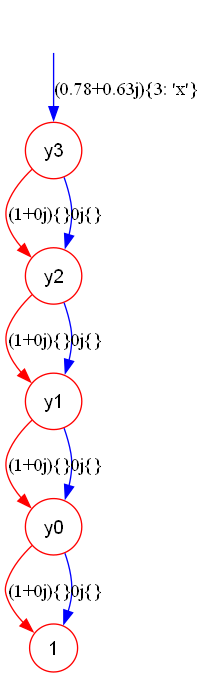

In [12]:
cir_head = QuantumCircuit(n+1)
t_start = time.time()
cir_end,_ = state_pre(tdd.self_copy())
print(time.time()-t_start)
print('1')
tdd_new = extend_tdd(tdd)
# print('2')
tdd_new2 = update_tdd(tdd_new,cir_head,cir_end)
print('3')
tdd_new2 = renormalize(tdd_new2)
print('4')
print(is_successful(tdd_new2,n))
tdd_new2.show()

In [13]:
n=3
m=100
g_num = 0
g_num2=0
g_num3=0
r = 20
tt = 0
for k in range(r):
    # if k%10==0:
    print(k)
    k+=1
    cir=gen_cir('Random_Clifford_T',n,m)
    tdd2=simulate(cir,True,n)
    print('node:',tdd2.node_number())
    cir_head = QuantumCircuit(n+1)
    t_start = time.time()
    cir_end,_ = state_pre(tdd2)
    print(time.time()-t_start)#只统计态制备的时间，以及所生成电路的复杂度
    tdd_new = extend_tdd(tdd2)
    tdd_new2 = update_tdd(tdd_new,cir_head,cir_end)
    tdd_new2 = renormalize(tdd_new2)
    if not is_successful(tdd_new2,n):
        print('find_one')
        break


0
node: 4
0.07832193374633789
1
node: 4
0.06006884574890137
2
node: 8
0.20399737358093262
3
node: 6
0.4007725715637207
4
node: 4
0.057126522064208984
5
node: 5
0.11986970901489258
6
node: 4
0.07825613021850586
7
node: 6
0.20117712020874023
8
node: 5
0.11428213119506836
9
node: 4
0.047466278076171875
10
node: 4
0.07910799980163574
11
node: 6
0.17635512351989746
12
node: 4
0.07851958274841309
13
node: 4
0.016243457794189453
14
node: 5
0.06312131881713867
15
node: 8
0.4380650520324707
16
node: 7
0.18437528610229492
17
node: 8
0.18229126930236816
18
node: 7
0.4256441593170166
19
node: 5
0.09755396842956543


{-1: -1, 0: 'y0', 1: 'y1', 2: 'y2', 3: 'y3', 4: 'y4'}
0.013815641403198242


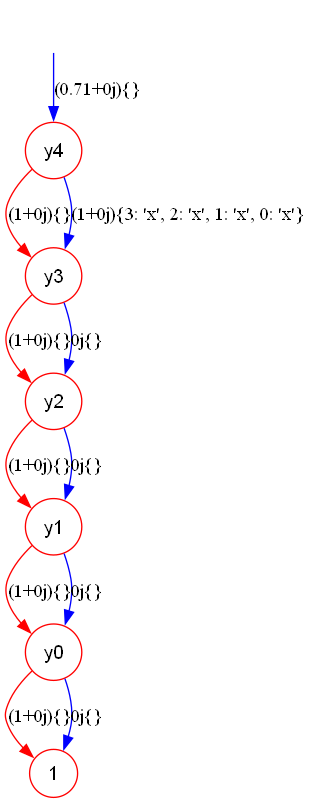

In [14]:
n=5

def get_GHZ(n):
    cir = QuantumCircuit(n)
    cir.h(n-1)
    for k in range(n-1):
        cir.cx(n-1,k)
    return cir

cir=get_GHZ(n)
cir.draw()
t_start = time.time()
tdd=simulate(cir,True,n)
print(tdd.key_2_index)
print(time.time()-t_start)
# tdd=renormalize(tdd)
tdd.show()